# PART 1: Diagnosing Breast Cancer

In this section, we will develop a models to diagnose breast cancer. We will use the Wisconsin Breast Cancer dataset sourced from https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29.

From the attribute information provided by the source, this dataset should contain the following variables and 569 instances:
1) ID number <br>
2) Diagnosis (M = malignant, B = benign) <br>
3) Ten real-valued features are computed for each cell nucleus:<br>
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)
    

# 1.Import libraries and Data

We will first import the data and required libraries, and inspect the dataset to ensure it has the expected variables and instance counts.

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, precision_score, recall_score,silhouette_samples,accuracy_score,silhouette_score
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram,fcluster

In [42]:
#Load in dataset
dataset = pd.read_csv("breast-cancer.csv")

In [5]:
#View first 5 rows of dataset
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


Viewing the head of the dataset, we can see that all required variables are present. We can find more detail into the dataset attributes by using the .info() method as below:

In [6]:
#View dataset feature attributes
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      569 non-null    int64  
 1   diagnosis               569 non-null    object 
 2   radius_mean             569 non-null    float64
 3   texture_mean            569 non-null    float64
 4   perimeter_mean          569 non-null    float64
 5   area_mean               569 non-null    float64
 6   smoothness_mean         569 non-null    float64
 7   compactness_mean        569 non-null    float64
 8   concavity_mean          569 non-null    float64
 9   concave points_mean     569 non-null    float64
 10  symmetry_mean           569 non-null    float64
 11  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 53.5+ KB


As above, we can see that there are 569 non-null instances as expected for each of the 12 variables. Another observation from above is that the variable 'id' can be dropped as it is irrelavant in the context of cancer classification.

# 2. Exploratory Data Analysis

We will now perform exploratory data analysis on the breast cancer dataset. Here, we will investigate the main characteristics of the data using visualisation techniques. First we will have a look at the proportion of target classes in the dataset using a count plot. This will let us know whether we will need to apply stratified splitting for the training and test sets so that they have the same proportion of target classes.

[Text(0, 0, '212'), Text(0, 0, '357')]

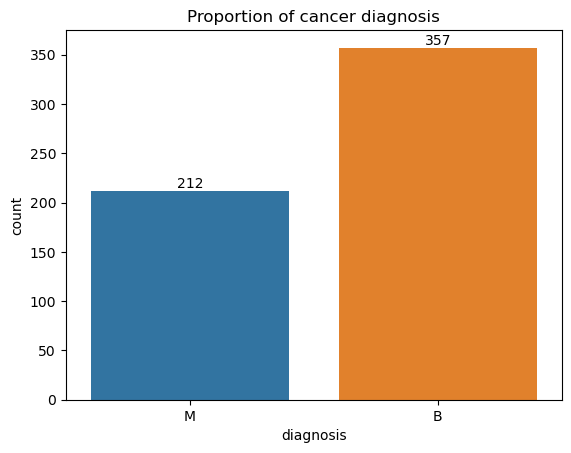

In [15]:
#Plot countplot of diagnosis classes
plt.title("Proportion of cancer diagnosis")
ax = sns.countplot(dataset, x="diagnosis")
ax.bar_label(ax.containers[0])

From the plot above, we can see that the target classes are imbalanced. The majority (357) of instances in the dataset have a class of B (benign), while the miniority (212) have a target classes of M (malignant). As such, we will need to apply straitified splitting during the train test splits.

Next, we will have a look at the correlations of input features. Features which are strongly linearly correlated with each other may be dropped with minimal loss of information. This is advantageous as we can reduce computation times, while also reducing model complexity and overfitting.

Text(0.5, 1.0, 'Input feature correlations')

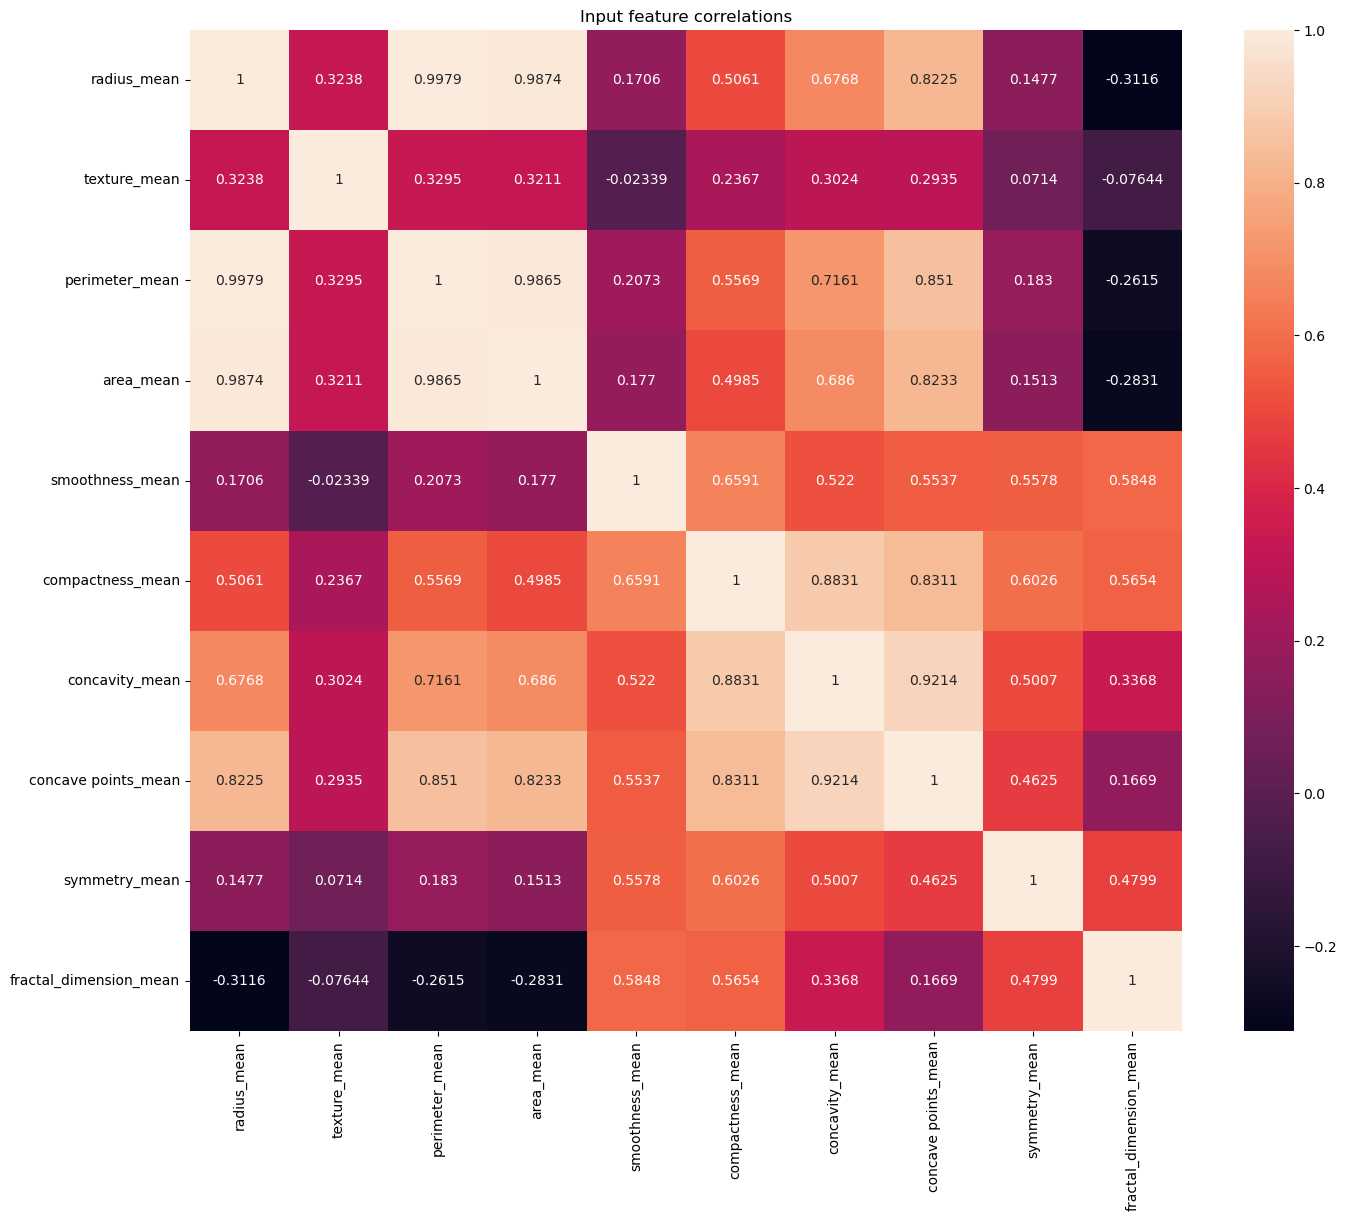

In [25]:
#Plot heatmap for correlations between input features except id

#Determine correlations between features using pearsons
correlations = dataset.iloc[:,2:].corr(method='pearson')

#Plot correlations in a heatmap
plt.figure(figsize=(16, 13))
sns.heatmap(correlations,annot = True,fmt=".4g")
plt.title("Input feature correlations")

From the heat map above, we can see that the variables 'area_mean', 'perimiter_mean', and 'radius_mean' are all strongly correlated with each other, having correlations of up to 0.99. As such, we can drop 2 of these variables and keep only one. For this project, we will use the variable radius_mean.

Next, we will plot a strip plot of input features to measure how well each feature is at seperating the target classes.

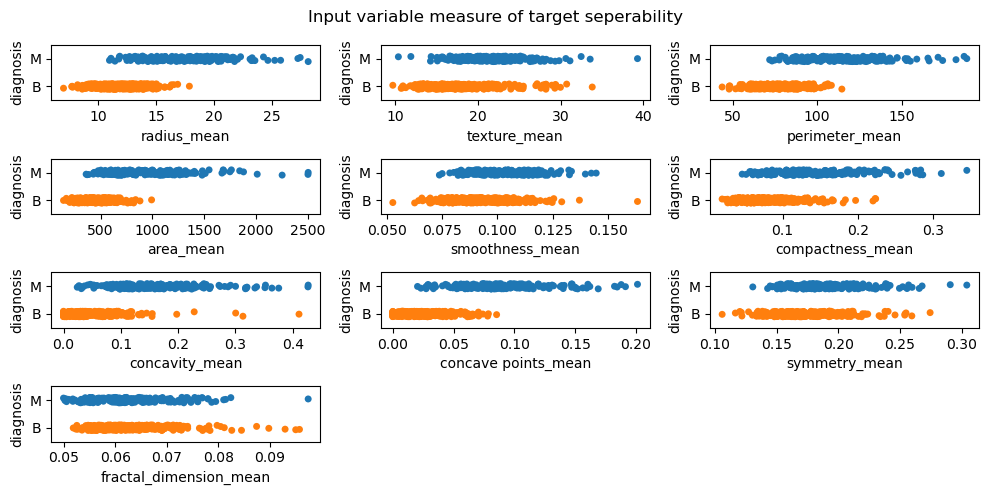

In [37]:
#Plotting strip plots to see distribution of variables for each class
ax =plt.figure(figsize=(10,5))
for i in range(1,11):
    plt.subplot(4,3,i)
    sns.stripplot(x=dataset.iloc[:,i+1],y=dataset['diagnosis'],hue=dataset['diagnosis'],legend = False)
plt.suptitle("Input variable measure of target seperability")
ax.tight_layout()


From the strip plots above we can see that the following variables have a high degree in separating the target classes:
- radius_mean, where values > ~17 have a higher proportion of class M
- perimeter_mean, where values > ~120 have a higher proportion of class M
- area_mean, where values > ~1000 are have a higher proportion of class M
- compact_ness, where values > ~ 0.18 have a higher proportion of class M
- radius_mean, where values > ~0.15 have a higher proportion of class M
- radius_mean, where values > ~0.08  have a higher proportion of class M

# 3. Feature Engineering

In this section, we will prepare the dataset for model training. First we will drop any unrequired variables that were identified from the dataset inspection and exploratory data analysis. We then divide the dataset in to input features and target variable. In the context of this dataset, as we want to detect cancer, we will set class 'M' as the target class,class '1', and class 'B' to '0'. 

In [45]:
#Dropping id, area_mean, and perimeter_mean
dataset_dropped = dataset.drop(['id', 'area_mean','perimeter_mean'],axis=1)

#Splitting dataset into input and target feature datasets
X = dataset_dropped.iloc[:,1:]
y = dataset_dropped["diagnosis"]

#Changing class 'M' to '1', and class "B" to '0'
y.replace({'B': 0, 'M': 1}, inplace=True)

We will now split the dataset into training and test sets using a 80/20 split ratio. As found in the exploratory data analysis, the dataset is imbalanced. As such, we will utilise a stratified split so that training and test sets have similar proportions of target classes.

Finally we perform feature scaling on the input variables using standard scaling to allow for faster convergence, and prevent feature dominance/bias. Standardisation is applied to the data post split to prevent data leakage. 

In [46]:
#Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)

#Fit scaler object onto training set
scaler = StandardScaler()
scaler.fit(X_train)

#Apply standard scaling to train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Model Training

## 4.1 Logistic Regression Model

We now train a logistic regression model to classify malignant tumours. First we will perform hyperparameter tuning to determine the best hyper-parameters for model performance. These hyperparameters effect the model's training process, and therefore it is important to determine the best values to optimise model performance. To do this, we will employ a grid-search to determine the best values for the following hyperparameters:

- C: Determines the inverse of regularisation strength. Smaller values of C will result in stronger regularisation, therefore reducing overfitting and model complexity, while larger values will result in weaker regularisation.
- fit_intercept: Determines whether a bias or intercept should be applied to the decision function. A bias term allows for the decision function to shift from the origin (0,0), allowing for more flexibility and complex relationships

3-fold cross-validation will be used so that we can test the models ability to predict unseen data (using validation sets) on the different hyperparameters.

In [68]:
log_grid = LogisticRegression(random_state=123)
parameters = {'C':[0.01,0.1,1,10,100],
              'fit_intercept':[False,True]}

#Perform grid search on knn model with 3-fold cross validation on training set
grid_search = GridSearchCV(log_grid, parameters,cv=3,scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("-------------------------------Grid Search Results:----------------------------------------")
pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1).sort_values(by="Accuracy")

-------------------------------Grid Search Results:----------------------------------------


,C,fit_intercept,Accuracy
1,0.01,True,0.903276
8,100.00,False,0.914256
6,10.00,False,0.916463
9,100.00,True,0.920864
0,0.01,False,0.920951
7,10.00,True,0.923057
2,0.10,False,0.923129
4,1.00,False,0.927515
3,0.10,True,0.931843
5,1.00,True,0.931872


After performing a grid search for C and fit_intercept over the values [0.01,0.1,1,10,100] and [False,True] respectively, we can see that hyperparameters of C = 1 and fit_intercept = True achieved the best results, yielding a cross-validation accuracy of 0.931872. Therefore, these values will be selected for our logistic regression model trained below.

In [96]:
#Train a logistic model with the optimal parameters found above
logistic_model = LogisticRegression(C=1, fit_intercept = True,random_state=123)
logistic_model.fit(X_train_scaled,y_train)

#Classify training and test sets using logistic regression model with optimal hyperparameters for C and fit_intercept
logistic_model_test_pred = logistic_model.predict(X_test_scaled)

## 4.2 Decision Tree

We now train a logistic regression model to perform the same classification task. Hyperparameter tuning  will be performed again to determine the best hyper-parameters for model performance. To do this, we will employ a grid-search to determine the best values for the following hyperparameters:

- max_depth: Determines the maximum depth the decision tree can grow to
- min_samples_leaf:  Determines the minimum samples a leaf node has to have
- min_samples_split: Determines the minimum samples a leaf node has to have before splitting

3-fold cross-validation will be used so that we can test the models ability to predict unseen data (using validation sets) on the different hyperparameters.

In [75]:
tree_grid = DecisionTreeClassifier(random_state=123)
parameters = {'max_depth':[i for i in range(1,10)],'min_samples_leaf':[1,2,3,4,5,10,20,30,40,50],
              'min_samples_split':[2,3,4,5,10,20,30,40,50]}

#Perform grid search on knn model with 3-fold cross validation on training set
grid_search = GridSearchCV(tree_grid, parameters,cv=3,scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("\n----------------Grid Search Results:-----------------")
pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1).sort_values(by="Accuracy")


----------------Grid Search Results:-----------------


,max_depth,min_samples_leaf,min_samples_split,Accuracy
145,2,20,3,0.903334
601,7,20,40,0.903334
600,7,20,30,0.903334
599,7,20,20,0.903334
598,7,20,10,0.903334
...,...,...,...,...
216,3,5,2,0.936345
220,3,5,10,0.936345
217,3,5,3,0.936345
219,3,5,5,0.936345


After performing a grid search for 'max_depth', 'min_samples_leaf', and 'min_samples_split' over the values [1,2,3,4,5,6,7,8,9], [1,2,3,4,5,10,20,30,40,50] and [2,3,4,5,10,20,30,40,50] respectively, we can see that hyperparameters of 'max_depth' = 3, 'min_samples_leaf' = 5, and 'min_samples_split' = 4  achieved the best results, yielding a cross-validation accuracy of 0.936345. Therefore, these values will be selected for our logistic regression model trained below.

In [47]:
#Train a Decision Tree Classifier with the optimal parameters found above
decision_tree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 5, min_samples_split=4,random_state=123)
decision_tree.fit(X_train_scaled,y_train)

#Classify training and test sets using logistic regression model with optimal hyperparameters for C and fit_intercept
decision_tree_test_pred = decision_tree.predict(X_test_scaled)

## 4.3 Logistic Regression Model vs Decision Tree performance comparison

We will now compare the results of the Logistic Regression model with Decision Tree in malignant tumour classification. First we will look at the confusion matrices of each model. The confusion matrices show the proportion of correct and incorrect classifications for the positive class (1) and negative class (0).

Text(0.5, 1.0, 'Decision Tree Classifier Confusion Matrix')

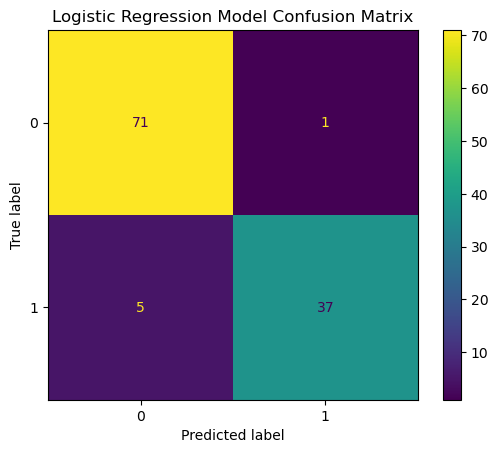

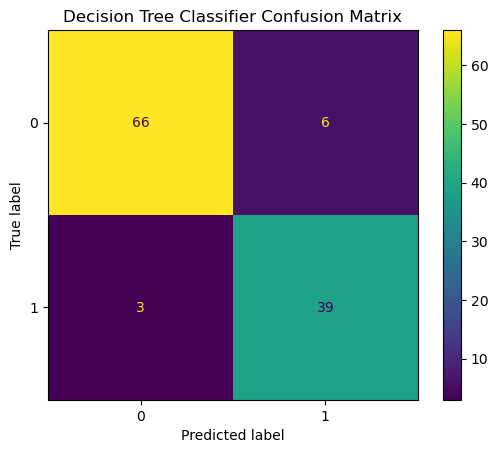

In [97]:
#Using model predictions, find confusion matrices
conf_matrix_log = confusion_matrix(y_test, logistic_model_test_pred)
conf_matrix_tree = confusion_matrix(y_test, decision_tree_test_pred)


#Plot confusion matrices of each model
conf_matrix_log_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_log,display_labels=(0,1))
conf_matrix_tree_plot = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tree,display_labels=(0,1))
conf_matrix_log_plot.plot()
plt.title("Logistic Regression Model Confusion Matrix")
conf_matrix_tree_plot.plot()
plt.title("Decision Tree Classifier Confusion Matrix")

From the confusion matrices above, we can see that the logistic regression model wrongly classified five class 1 instances as class 0, and one class 0 instance as class 1. The decision tree, however, wrongly classified three class 1 instances as class 0, and 6 class 0 instances as class 1. 

While the logistic regression model achieved a higher accuracy, having 6 incorrect classifications compared to the 9 incorrect classifications made by the decison tree, the decision tree was able to detect class 1's in particular with more accuracy. In the context of the classification task, we ideally want to detect as much people with malignant tumours as possible, and therefore a models ability to correctly predict class 1 instances should take priority. 

Taking this into consideration, we will now look at the each of the models' accuracies,recall, and precision.

In [339]:
#Caluclate accuracy of logistic and decision tree models
log_accuracy = accuracy_score(y_test,logistic_model_test_pred)
tree_accuracy = accuracy_score(y_test,decision_tree_test_pred)

#Caluclate precision of logistic and decision tree models
log_precision = precision_score(y_test,logistic_model_test_pred)
tree_precision = precision_score(y_test,decision_tree_test_pred)

#Caluclate recall of logistic and decision tree models
log_recall = recall_score(y_test,logistic_model_test_pred)
tree_recall = recall_score(y_test,decision_tree_test_pred)


#Print both model's results
print("Logistic Regression Model Test Set Results:")
print(f"Accuracy: {log_accuracy}")
print(f"Precision: {log_precision}")
print(f"Recall: {log_recall}")

print("\nDecision Tree Classifier Test Set Results:")
print(f"Accuracy: {tree_accuracy}")
print(f"Precision: {tree_precision}")
print(f"Recall: {tree_recall}")

Logistic Regression Model Test Set Results:
Accuracy: 0.9473684210526315
Precision: 0.9736842105263158
Recall: 0.8809523809523809

Decision Tree Classifier Test Set Results:
Accuracy: 0.9210526315789473
Precision: 0.8666666666666667
Recall: 0.9285714285714286


From the results above, we can see that the logistic regression model outperforms the decision tree in accuracy and precision, seeing 2% and 11% increases respectively. However, as mentioned prior, classification of class 1 instances is our priority. Therefore the recall (the proportion of positive cases detected) should be the most important metric. In this case, the decision tree performed the best, achieving a recall of 0.92 compared to 0.88, and only incorrectly classifying 3 class 1 instances incorrectly compared to 5. As such, it is reccomended that in a clinical setting, the decision tree would be more appropriate.

# 4.4 Feature Importances of Logistic and Decision Tree Models

In this section, we will now compare the importances of features in classification of malignant tumours based on each model. 

For the logistic regression model, we can determine feature importances by looking at the coefficients of the parameters in the logistic model. Larger coefficent absolute values will indicate stronger influence in classification result, while smaller values indicate weaker influence/importance. Feature importances of decision trees, however, are determined by their degree in reducing the likelihood that a random instance will be incorrectly classified at a tree split/decision node. This is known as Gini Impurity. 

In [141]:
#extract logistic regression model coefficients
coefficients = logistic_model.coef_.flatten()
features = np.array(X.columns)

#Sort the coefficients and the list of corresponding input features accordingly in descending order
sort_indices = np.argsort(-np.abs(coefficients))
sorted_coefficients = coefficients[sort_indices]
sorted_features = features[sort_indices]

#Print coefficients of each feature
print("Logistic Regression feature coefficients\n")
for i in range(len(sorted_coefficients)):
    print(f"{sorted_features[i]} coefficients: {sorted_coefficients[i]}")
    

#extract decision tree feature importances
importances = decision_tree.feature_importances_
sort_indices = np.argsort(-importances)

#Sort the feature importances and the list of corresponding input features accordingly in descending order
sorted_importances = importances[sort_indices]
sorted_features = features[sort_indices]

#Print feature of each feature
print("\n\nDecision Tree feature importances\n")
for i in range(len(sorted_coefficients)):
    print(f"{sorted_features[i]} feature importance: {sorted_importances[i]}")

Logistic Regression feature coefficients

radius_mean coefficients: 2.406043968136712
concave points_mean coefficients: 1.9008385757279558
texture_mean coefficients: 1.2610466009857935
concavity_mean coefficients: 0.9683687174569615
smoothness_mean coefficients: 0.7456005801214959
fractal_dimension_mean coefficients: -0.5007590582254918
symmetry_mean coefficients: 0.37103217204502237
compactness_mean coefficients: -0.2611864267512136


Decision Tree feature importances

concave points_mean feature importance: 0.8061330108013122
texture_mean feature importance: 0.09832857318229343
radius_mean feature importance: 0.055919084943631445
concavity_mean feature importance: 0.03961933107276284
smoothness_mean feature importance: 0.0
compactness_mean feature importance: 0.0
symmetry_mean feature importance: 0.0
fractal_dimension_mean feature importance: 0.0


From the results above, we can see that both models consider 'radius_mean', 'concave points_mean' and 'texture_mean' as the top three important features in classification of malignant tumours. Similarly, they also both consider the features 'compactness_mean', 'symmetry_mean', and 'fractal_dimension_mean' as the bottom three for importances in classfication.

However, unlike the logistic regression model, the decision tree classifier identifies the feature 'concave points_mean' as the most important, having a substantially higher feature importance of 0.8 compared to 'texture_mean'(0.098) and 'radius_mean' (0.05). The logisitic regression model identifies 'radius_mean' as the most important, having a coefficient of 2.4, which is not substantially higher then the next highest coffient, 1.9, for 'concave points_mean', unlike the case for the decision tree. Furthermore, the decision tree classifier identfied a feature importance of 0 for the bottom four features, while the logistic regression model assigned them non-zero coefficients (albeit lower coefficients compared to the top three)

# 4.4 Principal Component Analysis

In this section, we will investigate the performance of models in malignant tumour classification when we apply principal component analysis (PCA) on the breast cancer dataset. PCA is used to reduce the dimensions of datasets, while trying to capture as much variance seen in the original dataset to prevent information loss.

As scales affect PCA, we will need to first standardise our data. We will then evaluate the variance explained by the first two principal components.

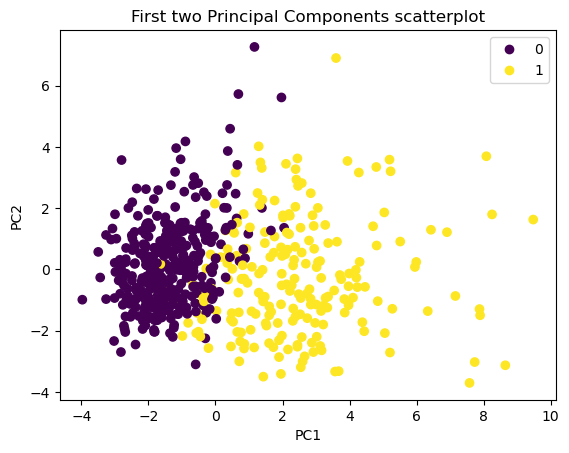

In [48]:
#Standardise Input Features
scaler_PCA = StandardScaler()
X_scaled_pca = scaler_PCA.fit_transform(dataset.iloc[:,2:])

#Perform PCA and plot first two prinicpal components
pca = PCA(n_components=2)
PCA_data = pca.fit_transform(X_scaled_pca)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("First two Principal Components scatterplot")
plot = plt.scatter(PCA_data[:,0],PCA_data[:,1],c=y,label="Target Class")
plt.legend(handles=plot.legend_elements()[0], labels=['0','1'])



The plot above displays the first two principal components. We can see that classes are seperated relatively well. PCA1 in particular has a high degree in separating the target classes, with a higher proportion of class 1 instances having a high PC1 and vice versa. We can have a look at the explained variance captured by each component below:

In [202]:
#Print explained varience of each component
print(f"Principal component 1 explained variance: {pca.explained_variance_ratio_[0]}")
print(f"Principal component 2 explained variance: {pca.explained_variance_ratio_[1]}")

Principal component 1 explained variance: 0.5478587991720022
Principal component 2 explained variance: 0.2518713585406174


As expected, the principal component 1 explains the most variance of 0.548, followed by the second principal component which explains a variance of 0.252 of the original data. Altogether, both components explain a variance of ~0.8 of the original data.

We will produce a biplot by adding the loading vectors of each input feature onto the graph. The magnitudes and orientations of the vectors will represent the loadings and correlations to the principal components respectively. This will allow us to have a better view of the relationships between the original input features and the principal components, as well as relationships between input variables themselves (e.g correlation). For this plot, the top and right axis represent the features' loadings on PC1 and PC2 respectively.

(-8.268263792940008, 8.268263792940008)

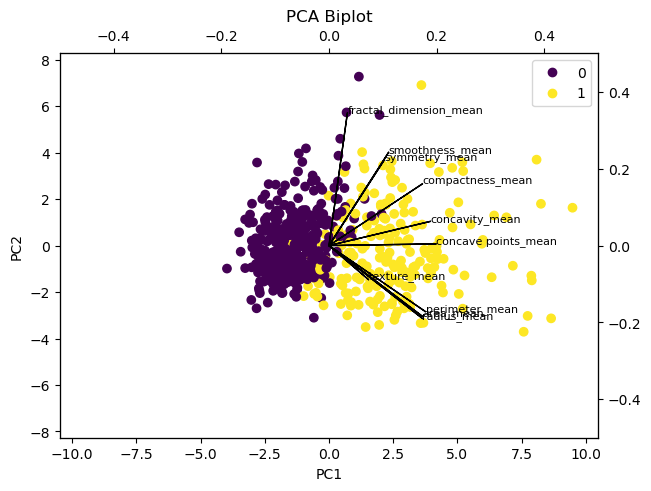

In [49]:
#Plot the PCA1 vs PCA2 plot again, but include loading vectors of each feature
fig, ax = plt.subplots(layout='constrained')
fig.figsize=(17,17)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA Biplot")
features = dataset.iloc[:,2:].columns
feature_loadings = pca.components_
ax.scatter(PCA_data[:,0],PCA_data[:,1],c=y,label="Target Class")
plt.legend(handles=plot.legend_elements()[0], labels=['0','1'],title="Class")

for i in range(len(features)):
    ax.arrow(0, 0, feature_loadings[0, i]*10, feature_loadings[1, i]*10)
    ax.text(feature_loadings[0, i] * 10, feature_loadings[1, i] * 10, features[i], fontsize=8)

ax2 = ax.twiny()
ax3 = ax.twinx()
ax2.set_xlim(-0.5,0.5)
ax3.set_ylim(-0.5,0.5)
ax.set_xlim(-np.abs(max(PCA_data[:,0]))-1,np.abs(max(PCA_data[:,0]))+1)
ax.set_ylim(-np.abs(max(PCA_data[:,1]))-1,np.abs(max(PCA_data[:,1]))+1)


From the biplot above, we can interpret the following:
- Perimeter_mean, area_mean, and radius_mean are strongly linearly correlated as their loading vectors have similar orientations and magnitudes
- Instances which have high PC1 are indicated to have higher concavity_mean, concave points_mean, perimeter_mean, area_mean, texture_mean, and radius mean. This is indicated by their magnitude in the PC1 direction. In particular, concave_points_mean, perimeter_mean, area_mean and radius_mean have the highest loading magnitude for PC1, and therefore higher influence in PC1. 
- Instances which have a high PC2 are indicated to have a higher fractal_dimension_mean, smiithness_mean, and symmetry_mean. In particular, fractal_dimension_mean has the highest loading vector magnitude in the direction of PC2

Observing the graph, we can see that in general, instances having a higher PC1 are typically class 1. As such, we can determine that the variables concavity_mean, perimeter_mean, area_mean, radius_mean, and concave points_mean are more related to tumour status as these variables, as mentioned above, have a high loading factor to PC1(indicated by their loading factor magnitude vector in the PC1 direction). Conversely, fractal dimension should have the least relavance to tumour status as it has the lowest loading factor to PC1. These importances are similar when compared to feature importances found by the decision tree and logistic model, with all three cases identifying radius_mean, concave points_mean as key variables in tumour status. Similarly, both models also identified factal_dimension_mean, smoothness_mean and symmetry_mean as weak predictors for tumour status.



We will now train a model using PCA and evaluate it's performance. First, we determine the minimum number of principal components we will need to achieve an explained variance of at least 95%.

In [50]:
#Determining the minimum number of principal components required to retain 95% of the explained variance.
for i in range(1,10):
    pca_2 = PCA(n_components=i)
    PCA_data_2 = pca_2.fit_transform(X_scaled_pca)
    total = sum(pca_2.explained_variance_ratio_)
    if total >= 0.95:
        print(f"Minimum number of principal components: {i}")
        print(f"Total explain variance: {sum(pca_2.explained_variance_ratio_)}")
        break

Minimum number of principal components: 5
Total explain variance: 0.9749465381739584


The minimum number of components was determined to be 5. As such, we now have a dataset of dimension 5 for inpu features. Using the 5 principal components produced, we will now train a decision tree to evaluate it's performances against the decision tree trained on the original dataset. This will include scaling the principal components beofre training. The decision tree for the PCA model will utilise the same hyperparameters found in  section 4.2 to allow for effective and fair comparisons.

In [350]:
#Split dataset into training and test sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(PCA_data_2, y, test_size=0.2, random_state=1,stratify=y)

#Fit scaler object onto training set
scaler = StandardScaler()
scaler.fit(X_train_pca)

#Apply standard scaling to train and test sets
X_train_scaled_pca = scaler.transform(X_train_pca)
X_test_scaled_pca = scaler.transform(X_test_pca)


#Train a Decision Tree Classifier with the optimal parameters found above
decision_tree_pca = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 5, min_samples_split=4,random_state=123)
decision_tree_pca.fit(X_train_scaled_pca,y_train)

#Classify training and test sets using logistic regression model with optimal hyperparameters for C and fit_intercept
decision_tree_pca_test_pred = decision_tree_pca.predict(X_test_scaled_pca)

#Caluclate accuracy of logistic and decision tree models
pca_tree_accuracy = accuracy_score(y_test,decision_tree_pca_test_pred)
tree_accuracy = accuracy_score(y_test,decision_tree_test_pred)

#Caluclate precision of logistic and decision tree models
pca_tree_precision = precision_score(y_test,decision_tree_pca_test_pred)
tree_precision = precision_score(y_test,decision_tree_test_pred)

#Caluclate recall of logistic and decision tree models
pca_tree_recall = recall_score(y_test,decision_tree_pca_test_pred)
tree_recall = recall_score(y_test,decision_tree_test_pred)


#Print both model's results
print("PCA Decision Tree Test Set Results:")
print(f"Accuracy: {pca_tree_accuracy}")
print(f"Precision: {pca_tree_precision}")
print(f"Recall: {pca_tree_recall}")

print("\nDecision Tree Classifier Test Set Results:")
print(f"Accuracy: {tree_accuracy}")
print(f"Precision: {tree_precision}")
print(f"Recall: {tree_recall}")

PCA Decision Tree Test Set Results:
Accuracy: 0.9473684210526315
Precision: 0.9285714285714286
Recall: 0.9285714285714286

Decision Tree Classifier Test Set Results:
Accuracy: 0.9210526315789473
Precision: 0.8666666666666667
Recall: 0.9285714285714286


When comparing the models, the model trained on hte prinicpal components interestingly performed better in accuracy and precision deispite loss in variance. Both models, however, achieved the same recall. Performance increases seen on the PCA model could possible be explained by PCA's dimensionialty and noise reduction from removal of irrelavant or noisy features during its process.

# PART 2: A clustering analysis on airlines safety records 

In this section, we will perform clustering analysis on the airline-safety dataset to investigate which airlines are simlar based on past safety records.

As per assignment notes, the dataset contains the following variables:
1. airline (asterisk indicates that regional subsidiaries are included)
2. avail seat km per week: available seat kilometres flown every week
3. incidents 85 99: total number of incidents, 1985-1999
4. fatal accidents 85 99: total number of fatal accidents, 1985-1999
5. fatalities 85 99: total number of fatalities, 1985-1999
6. incidents 00 14: total number of incidents, 2000-2014
7. fatal accidents 00 14: total number of fatal accidents, 2000-2014
8. fatalities 00 14: total number of fatalities, 2000-2014

    

# 1. Import Dataset

We will first import and inspect the dataset's features to ensure everything is as expected.

In [236]:
#Load in dataset
airline_dataset = pd.read_csv("airline-safety.csv")

In [4]:
#View head of dataset
airline_dataset.head()

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


In [199]:
#View attribute information of dataset
airline_dataset.describe()

,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
count,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,1.384621e+09,7.178571,2.178571,112.410714,4.125000,0.660714,55.517857
std,1.465317e+09,11.035656,2.861069,146.691114,4.544977,0.858684,111.332751
min,2.593733e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.740362e+08,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,8.029089e+08,4.000000,1.000000,48.500000,3.000000,0.000000,0.000000
75%,1.847239e+09,8.000000,3.000000,184.250000,5.250000,1.000000,83.250000
max,7.139291e+09,76.000000,14.000000,535.000000,24.000000,3.000000,537.000000


Inspecting the head of the dataset, we can see that one of the features is a string. As we want to cluster based on past safety records, we will drop and ignore this variable before K-means Clustering. Scaling of the dataset will be required given substantial differences in scales.

In [184]:
#Drop the first column in the dataset
airline_dataset_dropped = airline_dataset.iloc[:,1:]

#Standardise data
scaler_k_means = MinMaxScaler()
airline_dataset_dropped = scaler_k_means.fit_transform(airline_dataset_dropped)

# 2. K-means Clustering

We will now determine the best value for 'K' for the K-means clustering model. The K value controls the number of clusters or groups that the model aims to separate instances into. To do this, we will plot the silhouette graphs for each K-value. The silhouette plots display the silhouette coefficients for each sample/instance. The silhouette coefficient is used as a measure of how well the sample fits in it's cluster. As such tthese plots will visualise the performance of the clustering for each K value.

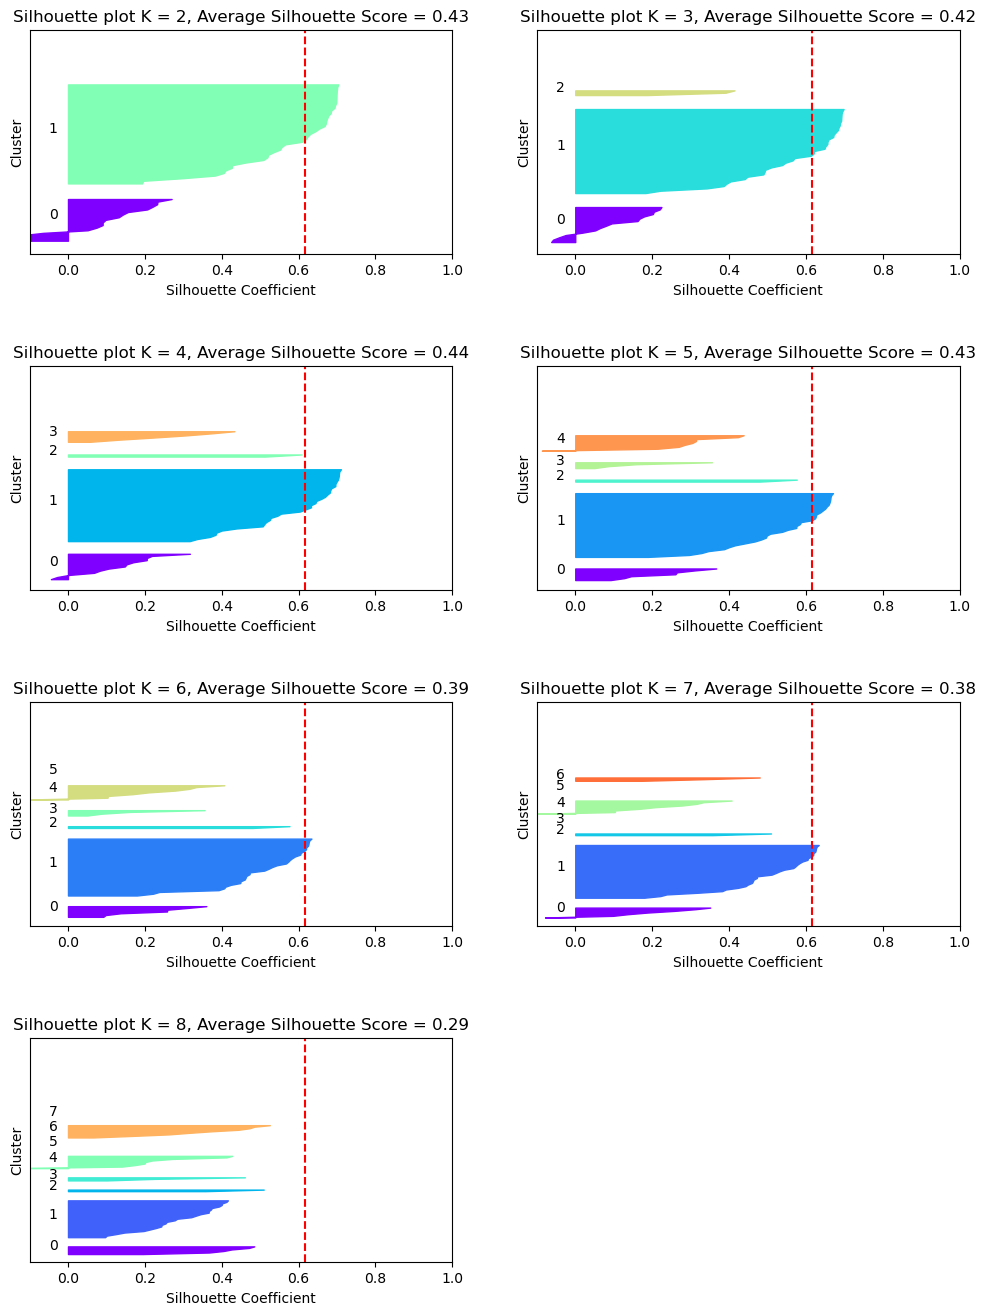

In [185]:
fig, ax = plt.subplots(4, 2, figsize=(12, 16))
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

# Flatten the ax array to access individual subplots
ax = ax.flatten()
fig.delaxes(ax[-1])

#For every K value from 2 to 8
for num_clusters in range(2,9):
  
    
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=5508,n_init="auto")
    labels = kmeans_model.fit_predict(airline_dataset_dropped)
    silhouette_avg_score = silhouette_score(airline_dataset_dropped, labels)
    silhouette_sample_scores = silhouette_samples(airline_dataset_dropped, labels)
    
    #Set axis parameters
    ax[num_clusters-2].set_title(f"Silhouette plot K = {num_clusters}, Average Silhouette Score = {silhouette_avg_score:.2f}")
    ax[num_clusters-2].set_xlim([-0.1, 1])
    ax[num_clusters-2].set_ylim([0, len(airline_dataset_dropped) + (num_clusters + 1) * 10])
    ax[num_clusters-2].set_xlabel("Silhouette Coefficient")
    ax[num_clusters-2].set_ylabel("Cluster")
    ax[num_clusters-2].set_yticks([])
    
    #Plot sillhouette for each cluster in the plot
    #y_lower sets the bound for cluster silhouettes so that there is a gap between them
    y_lower = 5
    for cluster_index in range(num_clusters):
        #Extract the sample scores for the current cluster and sort 
        curr_cluster_index = labels == cluster_index
        cluster_silhouette_values = silhouette_sample_scores[curr_cluster_index]
        cluster_silhouette_values.sort()

        #Upper bound for cluster silhouette
        y_upper = y_lower + cluster_silhouette_values.shape[0]

        #Plot silhouette
        color = plt.colormaps["rainbow"](cluster_index / num_clusters)
        ax[num_clusters-2].fill_betweenx(y=np.arange(y_lower, y_upper),x1=0,x2=cluster_silhouette_values,color=color)

        #Label silhouette with cluster index
        ax[num_clusters-2].text(-0.05, y_lower + 0.5 * (y_upper - y_lower), str(cluster_index),fontsize=10)

        #Update bounds so next sillhouette doesn't overlap with current one
        y_lower = y_upper + 5


    #Plot line indicating average silhouette score
    ax[num_clusters-2].axvline(x=silhouette_avg, color="red", linestyle="--")
    
    
    



From the silhouette plots above, we can see that as we increase K, the average silhouette score decreases from K=5 to 8. Furthermore, for K = 6,7 and 8, empty clusters are present. As such we should consider the first 4 (2,3,4,5) K values as they have the top four average silhouette scores. When comparing the distrubtion of silhouettes coefficients, plots for K = 4 has a higher proportion of samples which have a silhouette coefficient greater than or near the average silhouette score indicated by the dashed line. Furthermore, a K value of 4 produces the highest average silhouette score of 0.44. Therefore a value of 4 will be selected for K.

Using this selected K value, we will now perform K means clustering on the dataset, and analyse the main characteristics of each cluster with reference to the input features. To achieve this, we will look at the centroids of each cluster using the .clusters_centers_ attribute from sklearn. This centroid represents the arithmethic mean of all samples belonging the cluster, and as such, it's coordinates can provide us information about the whole cluster in general with reference to the input features.

In [197]:
#Train K-means clustering model
kmeans_model = KMeans(n_clusters=4, random_state=5508,n_init="auto")
labels = kmeans_model.fit_predict(airline_dataset_dropped)

#For each cluster, print out it's centroid coordinate for the corresponding input feature
for i in range(len(kmeans_model.cluster_centers_)):
    print(f"\n\n--------Cluster {i} centroid values--------")
    for j in range(len(kmeans_model.cluster_centers_[i])):
        print(f"{airline_dataset.iloc[:,1:].columns[j]} centroid value: {kmeans_model.cluster_centers_[i][j]}")



--------Cluster 0 centroid values--------
avail_seat_km_per_week centroid value: 0.11449483525668817
incidents_85_99 centroid value: 0.19433198380566802
fatal_accidents_85_99 centroid value: 0.31318681318681313
fatalities_85_99 centroid value: 0.5820273184759166
incidents_00_14 centroid value: 0.1923076923076923
fatal_accidents_00_14 centroid value: 0.33333333333333337
fatalities_00_14 centroid value: 0.09583154275891706


--------Cluster 1 centroid values--------
avail_seat_km_per_week centroid value: 0.11702542545367522
incidents_85_99 centroid value: 0.04172932330827067
fatal_accidents_85_99 centroid value: 0.05918367346938773
fatalities_85_99 centroid value: 0.06114819759679574
incidents_00_14 centroid value: 0.10714285714285715
fatal_accidents_00_14 centroid value: 0.06666666666666671
fatalities_00_14 centroid value: 0.02314445331205109


--------Cluster 2 centroid values--------
avail_seat_km_per_week centroid value: 0.9554040904335234
incidents_85_99 centroid value: 0.28289473

When looking at the centroid values for each feature in each cluster, we can see that there are some discernable characteristics of each cluster: 
- In Cluster 3, we can see that compared to other clusters, it shows a higher amount for fatal accidents and fatalities from 2000 - 2014, having values of 0.72 and 0.57 respectively. As such, airlines in this cluster would be considered as most unsafe compared to other airlines
- Cluster 2 on the otherhand, has higher values in fatal accidents and fatalities between 1985 and 1999, and available set km flown per week, compared to other clusters, having values of 0.714, 0.678 and 0.955 respectively. 
- Relative to other clusters, the values for all the input feature centroids for cluster 1 is much smaller, indicating that airlines in this cluster a relatively safer. 
- Finally for cluster 0, it is similar to cluster 2, in that it has a higher proportion of fatalities between 1985 to 1999, however it it has a substantially lower value (0.11 vs 0.95) for available set km flown per week, which is most likely why airlines in this cluster were not labeled as cluster 2.

For the K-means clustering, Min max scaling was performed. This is important as some features in the dataset have substantially different scales. For example, as found in the initial dataset inspection, avail_seat_km_per_week values go as high as  7.139291e+09, compared to other features which have scales of up to 534. This difference in scales will subsequently result in poorer convergence, as well as bias towards features. Therefore, it is important to perform scaling before K-Means. 
The feature 'airline' was also dropped prior to K-means as this is a string variable, and clustering can only work out numerical data using euclidian distances to determine clusters.

We will now perform K-means clustering focusing on two sets of variables to evaluate their performance change, and see if clusters change in terms of their characteristics relative to input features. Focusing on particular variables may improve performance by dropping out any irrelevant variables.
- Variables from years 1985 - 1999
- Varibles from 2000 - 2014

The same K value of 4 will be used. Datasets will need to be rescaled before K-means clustering

In [207]:
#Filter datasets based on 1985-1999 and 2000-2014 features
airline_dataset_8599 = airline_dataset.iloc[:,2:5]
airline_dataset_0014 = airline_dataset.iloc[:,5:9]


#Standardise subset datasets
scaler_8599 = MinMaxScaler()
scaled_airline_8599 = scaler_k_means.fit_transform(airline_dataset_8599)

scaler_0014 = MinMaxScaler()
scaled_airline_0014 = scaler_k_means.fit_transform(airline_dataset_0014)

In [220]:
#Train K-means clustering model using 1985-1999 variables
kmeans_model_8599 = KMeans(n_clusters=4, random_state=5508,n_init="auto")
labels = kmeans_model_8599.fit_predict(scaled_airline_8599)

print("----------------------1985 - 1999 Variables-------------------------") 
print(f"Average Cluster Silhouette Score: {silhouette_score(scaled_airline_8599, labels)}")
#For each cluster, print out it's centroid coordinate for the corresponding input feature
for i in range(len(kmeans_model_8599.cluster_centers_)):
    print(f"\n\n--------Cluster {i} centroid values--------")
    for j in range(len(kmeans_model_8599.cluster_centers_[i])):
        print(f"{airline_dataset.iloc[:,2:5].columns[j]} centroid value: {kmeans_model_8599.cluster_centers_[i][j]}")

----------------------1985 - 1999 Variables-------------------------
Average Cluster Silhouette Score: 0.5586505306057742


--------Cluster 0 centroid values--------
incidents_85_99 centroid value: 0.12246963562753035
fatal_accidents_85_99 centroid value: 0.22527472527472528
fatalities_85_99 centroid value: 0.4457225017972682


--------Cluster 1 centroid values--------
incidents_85_99 centroid value: 0.04800853485064009
fatal_accidents_85_99 centroid value: 0.06756756756756753
fatalities_85_99 centroid value: 0.04349583228087897


--------Cluster 2 centroid values--------
incidents_85_99 centroid value: 1.0
fatal_accidents_85_99 centroid value: 1.0
fatalities_85_99 centroid value: 0.23925233644859814


--------Cluster 3 centroid values--------
incidents_85_99 centroid value: 0.18421052631578946
fatal_accidents_85_99 centroid value: 0.4571428571428571
fatalities_85_99 centroid value: 0.8246728971962618


When focusing on only 1988 and 1999 variables, we can see that the clusters have definately changed. There has been an increase in average cluster silhouette score (0.56 vs 0.44), therefore indicating that samples are fitting in with their clusters much more well compareded to using the whole dataset for k-means.
\n As above the following characteristics of each cluster can be interpreted using their centroids:
- Cluster 3 repesent airlines which have high fatalities, having much higher values (0.82) for this variables compared to other clusters
- Cluster 2 represents airlines which have high incidents and fatal accidents, having a substantially higher centroid values (1 and 1) for these features compared to other clusters, thus indicating that airlines in this cluster were the most unsafe between 1985 - 1999
- Cluster 1 however represents airlines which all have low incididents, fatal accidents, and fatalities, with its centroid values being  much smaller relative to other clusters. As such, airlines in this cluster would be considered the safest in 1985-1999
- Cluster 0 seems to represent airlines which have a medium fatalities, and minor fatal accidents and incidents

In [222]:
print("\n \n \n----------------------2000 - 2014 Variables-------------------------")        
        
#Train K-means clustering model using 2000-2014 variables
kmeans_model_0014 = KMeans(n_clusters=4, random_state=5508,n_init="auto")
labels = kmeans_model_0014.fit_predict(scaled_airline_0014)
print(f"Average Cluster Silhouette Score: {silhouette_score(scaled_airline_0014, labels)}")

#For each cluster, print out it's centroid coordinate for the corresponding input feature
for i in range(len(kmeans_model_0014.cluster_centers_)):
    print(f"\n\n--------Cluster {i} centroid values--------")
    for j in range(len(kmeans_model_0014.cluster_centers_[i])):
        print(f"{airline_dataset.iloc[:,5:9].columns[j]} centroid value: {kmeans_model_0014.cluster_centers_[i][j]}")


 
 
----------------------2000 - 2014 Variables-------------------------
Average Cluster Silhouette Score: 0.5756013127579039


--------Cluster 0 centroid values--------
incidents_00_14 centroid value: 0.43229166666666663
fatal_accidents_00_14 centroid value: 0.6666666666666665
fatalities_00_14 centroid value: 0.14315642458100558


--------Cluster 1 centroid values--------
incidents_00_14 centroid value: 0.1015625
fatal_accidents_00_14 centroid value: 1.1102230246251565e-16
fatalities_00_14 centroid value: -1.3877787807814457e-17


--------Cluster 2 centroid values--------
incidents_00_14 centroid value: 0.29166666666666663
fatal_accidents_00_14 centroid value: 0.75
fatalities_00_14 centroid value: 0.7323091247672252


--------Cluster 3 centroid values--------
incidents_00_14 centroid value: 0.14583333333333331
fatal_accidents_00_14 centroid value: 0.3333333333333333
fatalities_00_14 centroid value: 0.14292364990689013


When focusing on only 2000 and 2014 variables, we can see that there has been an increase in average cluster silhouette score (0.58 vs 0.44) compared to using the entire dataset for k-means, and therefore indicating that samples are fitting in with their clusters much more well.
<br>As above the following characteristics of each cluster can be interpreted using their centroids:

- Cluster 2 repesent airlines which have high fatalities and fatal accidents, having much higher values (0.73 and 0.75) for these variables compared to other clusters, thus indicating that airlines in this cluster were unsafe relative to other airlines from 2000-2014
- Cluster 1 represents airlines which have low incidents, fatal accidents and fatalities, having much lower values (0.1, 1.1e-16,-1.38e-17) in these feature centroids compared to other clusters, indicating that airlines in this cluster were much more safe from 2000-2014
- Cluster 3 seems to represent airlines which have relatively low incidents and fatalities, and medium fatal incidents
- Cluster 0 seems to represent airlines which have a medium fatalities fatal accidents and incidents with minor fatalities

We will now perform K-means clustering considering three new features, and measure their performance. The ratio of 2000-2014 divided by 1985-1999 variables may improve clustering performance, given their improved ability in clustering samples when considered individually compared to using the whole dataset:
- The ratio of incidents_85_99 and incidents_00_14
- The ratio of fatal_accidents_85_99 and fatal_accidents_00_14
- The ratio of fatalities_85_99 and fatalities_00_14

The same K value of 4 will be used. As some of the 1985-1999 features contain 0, the ratio will not be able to be ouput. Therefore, we will consider only those airlines which contain non-zero values for 1985-1999 features.

In [238]:
#Filter datasets based on 1985-1999 and 2000-2014 features
airline_non_zero = airline_dataset[(airline_dataset['incidents_85_99'] != 0) & (airline_dataset['fatal_accidents_85_99'] != 0) & (airline_dataset['fatalities_85_99'] != 0)].copy()
airline_non_zero['incidents_ratio'] = airline_non_zero['incidents_00_14'] / airline_non_zero['incidents_85_99']
airline_non_zero['fatal_accidents_ratio'] = airline_non_zero['fatal_accidents_00_14'] / airline_non_zero['fatal_accidents_85_99']
airline_non_zero['fatalities_ratio'] = airline_non_zero['fatalities_00_14'] / airline_non_zero['fatalities_85_99']

airline_ratio_var = airline_non_zero[["incidents_ratio","fatal_accidents_ratio","fatalities_ratio"]]

#Standardise subset datasets
scaler_ratio = MinMaxScaler()
scaled_airline_ratio = scaler_ratio.fit_transform(airline_ratio_var)

#Train K-means clustering model using 1985-1999 variables
kmeans_model_ratio = KMeans(n_clusters=4, random_state=5508,n_init="auto")
labels = kmeans_model_ratio.fit_predict(airline_ratio_var)

print("----------------------Ratio Variables-------------------------") 
print(f"Average Cluster Silhouette Score: {silhouette_score(airline_ratio_var, labels)}")
#For each cluster, print out it's centroid coordinate for the corresponding input feature
for i in range(len(kmeans_model_ratio.cluster_centers_)):
    print(f"\n\n--------Cluster {i} centroid values--------")
    for j in range(len(kmeans_model_ratio.cluster_centers_[i])):
        print(f"{airline_ratio_var.columns[j]} centroid value: {kmeans_model_ratio.cluster_centers_[i][j]}")

----------------------Ratio Variables-------------------------
Average Cluster Silhouette Score: 0.5218602120359184


--------Cluster 0 centroid values--------
incidents_ratio centroid value: 0.27833487704769166
fatal_accidents_ratio centroid value: 0.15973084886128364
fatalities_ratio centroid value: 0.14149353713479007


--------Cluster 1 centroid values--------
incidents_ratio centroid value: 1.0
fatal_accidents_ratio centroid value: 1.25
fatalities_ratio centroid value: 14.813725490196079


--------Cluster 2 centroid values--------
incidents_ratio centroid value: 0.6190476190476191
fatal_accidents_ratio centroid value: 0.55
fatalities_ratio centroid value: 4.192317332999123


--------Cluster 3 centroid values--------
incidents_ratio centroid value: 1.4538690476190474
fatal_accidents_ratio centroid value: 0.2638888888888889
fatalities_ratio centroid value: 0.3360832358267767


Compared to task 2, considering only the ratios between the 1985-1999 and 2000-2014 features, the K-means model achieves a higher average cluser silhouette score of 0.52 compared to 0.44. However, compared to considering the 1985-1999 and 2000-2014 variables indivbidually which achieved average silhouette scores of 0.56 and 0.58 respectively, the model performs a bit worse. This could possibly be due to the removal of the instances which had 0 values for 1985-1999 features.

However, when looking at the centroids of each cluster, the characteristics of each cluster are well defined.
- Cluster 0, the ratios for 1985-1999 and 2000-2014 variables are much smaller compared to other clusters, indicating that airlines in this cluster in general were much unsafer in 1985-1999 compared to 2000-2014
- Cluster 1, the ratios for 1985-1999 and 2000-2014 variables are much higher compared to other clusters, in particular the the fatalities ration having a value of 14, indicating that airlines in this cluster in general were much unsafer and had more fatalities in  2000-2014 compared to 1985-1999
- Like Cluster 1, Cluster 2, the ratios for 1985-1999 and 2000-2014 fatalities ratios are much higher compared to clusers 0 1 and 3, having a value of 4. However if is differentiable by cluster 1 as it's ratios for incidents and fatal accidents are not as high. 
- Cluster 3 exhibits lower ratios for fatal_acidents and fatalities, however a high ratio centroid value for incidents ratio compared to the other three clusters

# PART 3: A clustering analysis on the US Arrests data

In this section, we will perform clustering analysis on the USArrests dataset. As per assignment specs the supplied dataset should contain 50 observations and 5 variables:
- Murder: murder arrests (per 100,000)
- Assault: assault arrests (per 100,000)
- Rape: rape arrests (per 100,000)
- UrbanPop: percent of the population living in urban areas


# 1. Import and inspect Dataset

We will first import the USArrests dataset and quickly inspect it to ensure that all features and observations match specifications.

In [247]:
#Load in dataset
usarrests_dataset = pd.read_csv("USArrests.csv")

In [248]:
#View head of dataset
usarrests_dataset.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [246]:
#View dataset attribute information
usarrests_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


From inspection, the dataset contains 50 observations with all expected input variables.

In [379]:
#Obtaining required input variables
X = usarrests_dataset.iloc[:,1:]

# 2.1 Hierachical Clustering

We will now perform hierarchical clustering on the usaarrests dataset. Euclidean distance with complete linkage will be used to cluster the states. Complete linkage involves computing all pairwise disimilarities between clusters, and as such considers the global structure of points. The denograph will be cut at a height in which 3 distinct clusters will be identfied.

In [345]:
#Perform hierchical clustrering on dataset. n_clusters set to 3 to cut denograph at a height resulting in 3 clusters
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')

#Predict the clusters of the dataset instances
prediction = hierarchical_cluster.fit_predict(X)

In [364]:
#Determine which state is in which cluster
class_0 = []
class_1 = []
class_2 = []
for i in range(len(prediction)):
    if prediction[i] == 0:
        class_0.append(usarrests_dataset["State"][i])
    if prediction[i] == 1:
        class_1.append(usarrests_dataset["State"][i])
    if prediction[i] == 2:
        class_2.append(usarrests_dataset["State"][i])
print(f"States in cluster 0\n: {class_0}")
print(f"\nStates in cluster 1\n: {class_1}")
print(f"\nStates in cluster 2\n: {class_2}")

States in class 0
: ['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina']

States in class 1
: ['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wisconsin']

States in class 2
: ['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri', 'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wyoming']


From the clustering model's predictions above, we can see which states have been partitioned into which clusters. To identify the characteristics of the states in these clusters, we will compute the means of each input feature for each cluster as follows:

In [414]:
#print the mean value of each feature in every cluster
print("Cluster 0 mean feature values")
print(usarrests_dataset[usarrests_dataset["State"].isin(class_0)].mean(numeric_only=True))

print("\n\nCluster 1 mean feature values")
print(usarrests_dataset[usarrests_dataset["State"].isin(class_1)].mean(numeric_only=True))

print("\n\nCluster 2 mean feature values")
print(usarrests_dataset[usarrests_dataset["State"].isin(class_2)].mean(numeric_only=True))

Cluster 0 mean feature values
Murder       11.8125
Assault     272.5625
UrbanPop     68.3125
Rape         28.3750
dtype: float64


Cluster 1 mean feature values
Murder       4.27
Assault     87.55
UrbanPop    59.75
Rape        14.39
dtype: float64


Cluster 2 mean feature values
Murder        8.214286
Assault     173.285714
UrbanPop     70.642857
Rape         22.842857
dtype: float64


From the means computed above, we can see that states in Cluster 0 have a much higher rate of crimes for murder, assault and rape when compared to the other two states, having values of 11.81, 272 and 68 respectively (arrests per 100000). It is also the second highest in highest in terms of urban population, having a value of 68% (% living in urban areas).

Cluster 1 states however, sees the lowest crime rates, having a mean if 4.27, 87.55 and 14.39 arrests per 100000 people for murder, assault and rape. States in Cluster 1 also having the lowest urban population, 59.75%.

Cluster 2 states have the second highest rates in crime for murder,assault,rape, seeing mean arrests of 8, 173 and 22 per 100000 people, while having the highest urban population of 70.64%.

We will now investigate the effect of scaling data to have zero mean and unit standard deviation, in hierachical clustering. Scaling will effect standardise the scales of all features. As such, all features will have the same weight in determining distance metrics and clusters.The same parameters for the cluster model trained above will be used.

In [413]:
#Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#perform hierachical clustering
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
prediction_scaled = hierarchical_cluster.fit_predict(X_scaled)

#determine which state is in which cluster
class_0_scaled = []
class_1_scaled = []
class_2_scaled = []
for i in range(len(prediction_scaled)):
    if prediction_scaled[i] == 0:
        class_0_scaled.append(usarrests_dataset["State"][i])
    if prediction_scaled[i] == 1:
        class_1_scaled.append(usarrests_dataset["State"][i])
    if prediction_scaled[i] == 2:
        class_2_scaled.append(usarrests_dataset["State"][i])
        
#print the mean of each feature variable for every cluster       
print("Cluster 0 mean feature values")
print(usarrests_dataset[usarrests_dataset["State"].isin(class_0_scaled)].mean(numeric_only=True))

print("\n\nCluster 1 mean feature values")
print(usarrests_dataset[usarrests_dataset["State"].isin(class_1_scaled)].mean(numeric_only=True))

print("\n\nCluster 2 mean feature values")
print(usarrests_dataset[usarrests_dataset["State"].isin(class_2_scaled)].mean(numeric_only=True))

Cluster 0 mean feature values
Murder        5.003226
Assault     116.483871
UrbanPop     63.838710
Rape         16.338710
dtype: float64


Cluster 1 mean feature values
Murder       14.0875
Assault     252.7500
UrbanPop     53.5000
Rape         24.5375
dtype: float64


Cluster 2 mean feature values
Murder       11.054545
Assault     264.090909
UrbanPop     79.090909
Rape         32.618182
dtype: float64


The results above show that scaling variables to have zero mean and unit standard deviation have a significant change the mean characteristics of each cluster. Before scaling, we can see that across clusters, the variance is quite high for the means of variables such as Assualt, which saw very high values in cluster 0, but low values in cluster 1. This difference could potentially result in clustering processes which Assault dominates the distance calculations.
After scaling however, we can see that the variance in the means across clusters is relatively stable and on similar scales.

In the context of this dataset, if we want to cluster states by crime rates, scaling should performed.

In [366]:
usarrests_dataset.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


From the describe function above, we can see that assault is the most common crime, having the highest max value, and highest mean value. Subsequently, during the cluster process, the feature assault will have the most influence, while lesser common crimes such as rape and murder will have less. As we want to cluster states by crime rates, all crimes should be put on a similar scale so that they have the same influence in the distance and cluster process.

# 2.2 Hierachical Clustering with PCA

In this section, we will perform hierachical clustering on the first two prinicpal components of the USArrests dataset using PCA. Like section 2.2, the dendrogram will be cut at a height in which there are three distinct clusters, and will utilise Euclidean distance and complete linking. 

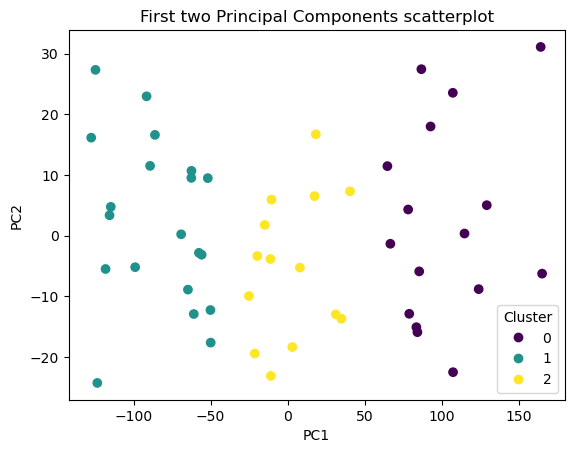

In [404]:
#Perform PCA and plot first two prinicpal components
pca = PCA(n_components=2)
PCA_data = pca.fit_transform(X)

hierarchical_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
prediction_pca = hierarchical_cluster.fit_predict(PCA_data)

#Plot prinipcal components
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("First two Principal Components scatterplot")
plot = plt.scatter(PCA_data[:,0],PCA_data[:,1],c=prediction_pca,label="Cluster")
plt.legend(handles=plot.legend_elements()[0], labels=['0','1','2'],title="Cluster")



The plot above displays the principal component 1 vs principal component 2. We can see that for values -150 to -50 for PC1, clusters are mostly cluster 0, for values -25 to 25, clusters are mostly cluster 2, and for values 75 to 150, clusters are of mostly class 3.

We will now determine the mean of each input feature for for the hierachical clustering performed on the principal components. These means will provide us information about the characteristics of each cluster.

In [415]:
#Determining mean values for the principal components 
class_0_pca = []
class_1_pca = []
class_2_pca = []
for i in range(len(prediction_pca)):
    if prediction_pca[i] == 0:
        class_0_pca.append(PCA_data[i])
    if prediction_pca[i] == 1:
        class_1_pca.append(PCA_data[i])
    if prediction_pca[i] == 2:
        class_2_pca.append(PCA_data[i])
        
print("Cluster 0 mean principal component values")
print(f"PC1 :{np.mean(class_0_pca,axis=0)[0]}")
print(f"PC2 :{np.mean(class_0_pca,axis=0)[1]}")


print("\n\nCluster 1 mean principal component values")
print(f"PC1 :{np.mean(class_1_pca,axis=0)[0]}")
print(f"PC2 :{np.mean(class_1_pca,axis=0)[1]}")

print("\n\nCluster 2 mean principal component values")
print(f"PC1 :{np.mean(class_2_pca,axis=0)[0]}")
print(f"PC2 :{np.mean(class_2_pca,axis=0)[1]}")


Cluster 0 mean principal component values
PC1 :102.14915513758902
PC2 :2.020235979887315


Cluster 1 mean principal component values
PC1 :-83.74157653250859
PC2 :1.982213314575242


Cluster 2 mean principal component values
PC1 :2.8889320320534404
PC2 :-5.14057442640726


When comparing the means of each feature variable to the hierachical clustering performed on the scaling data, the group means of the principal components have extremely high variability compared to the group means of the clusters clustered using the scaled data. For example Cluster 0 has a mean PC1 value of 102, while Cluster 1 has a dramatic drecrease, having a mean PC1 value of -83. Values for the clustering performed on the scaled data however remian realtively stable across clusters (e.g 115, 252,264)

To further evaluate the performance of the hierachical clustering model using the PCA components, we will now use K-means clustering on the first two principal components using K = 3. The centroids of the K-means clustering will be set to the feature means of each cluster obtained from the PCA hierachical clustering.

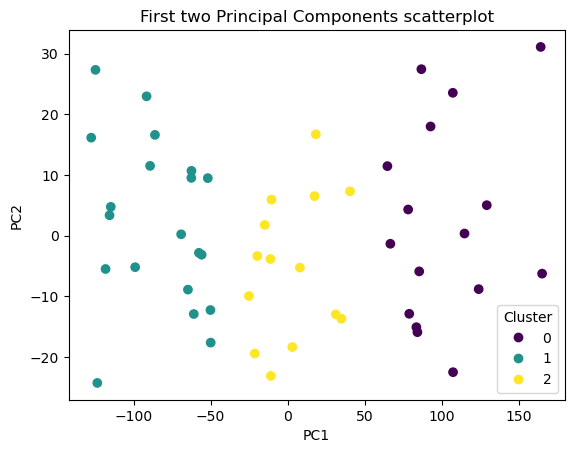

In [421]:
initial_centroids = [np.mean(class_0_pca,axis=0),
                    np.mean(class_1_pca,axis=0),
                    np.mean(class_2_pca,axis=0)]
kmeans_usarrest_pca = KMeans(n_clusters=3, random_state=5508,n_init=1,init=initial_centroids)
labels = kmeans_usarrest_pca.fit_predict(PCA_data)

#Plot prinipcal components
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("First two Principal Components scatterplot")
plot = plt.scatter(PCA_data[:,0],PCA_data[:,1],c=labels,label="Cluster")
plt.legend(handles=plot.legend_elements()[0], labels=['0','1','2'],title="Cluster")

In [422]:
#Determining mean values for the principal components 
class_0_pca = []
class_1_pca = []
class_2_pca = []
for i in range(len(labels)):
    if labels[i] == 0:
        class_0_pca.append(PCA_data[i])
    if labels[i] == 1:
        class_1_pca.append(PCA_data[i])
    if labels[i] == 2:
        class_2_pca.append(PCA_data[i])
        
print("Cluster 0 mean principal component values")
print(f"PC1 :{np.mean(class_0_pca,axis=0)[0]}")
print(f"PC2 :{np.mean(class_0_pca,axis=0)[1]}")


print("\n\nCluster 1 mean principal component values")
print(f"PC1 :{np.mean(class_1_pca,axis=0)[0]}")
print(f"PC2 :{np.mean(class_1_pca,axis=0)[1]}")

print("\n\nCluster 2 mean principal component values")
print(f"PC1 :{np.mean(class_2_pca,axis=0)[0]}")
print(f"PC2 :{np.mean(class_2_pca,axis=0)[1]}")

Cluster 0 mean principal component values
PC1 :102.14915513758902
PC2 :2.020235979887315


Cluster 1 mean principal component values
PC1 :-83.74157653250859
PC2 :1.982213314575242


Cluster 2 mean principal component values
PC1 :2.8889320320534404
PC2 :-5.14057442640726


When compared to the hierachical clustering, the K-means clustering with k=3 achieves the same principal component mean values for each cluster. Furthermore plots 